In [7]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask

In [8]:
# Start dask client
from dask.distributed import Client
client = Client() 
client

/global/homes/d/dbrooks/.conda/envs/myenv/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40453 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40453/status,
Dashboard: http://127.0.0.1:40453/status,Workers: 16
Total threads: 256,Total memory: 502.97 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43447,Workers: 16
Dashboard: http://127.0.0.1:40453/status,Total threads: 256
Started: Just now,Total memory: 502.97 GiB
Comm: tcp://127.0.0.1:33795,Total threads: 16
Dashboard: http://127.0.0.1:34689/status,Memory: 31.44 GiB
Nanny: tcp://127.0.0.1:43679,


In [9]:
# Load full ERA-5 datast
ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks={"time": 30},
    storage_options=dict(token='anon'),
)
ds

<xarray.Dataset> Size: 4PB
Dimensions:                                                          (
                                                                      time: 1323648,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 11MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    wave_spectral_skewness                                           (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    zero_degree_level                                                (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
Attributes:
    valid_time_start:       1940-01-01
    last_updated:           2025-11-03 02:00:15.082564+00:00
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-10-28

In [10]:
# Function for selecting ERA5 data
def get_era5_data_for_area(ds, var, bbox, start_time, end_time):
    """
    This function serves to grab ERA-5 data for a given variable
    for given lat-lon box for a given timeframe.

    Inputs:
    - ds (xarray.Dataset): ERA-5 dataset with all the variables.
    - var (str): Variable you want to grab from the data.
    - bbox (list/np.array): List of coordinates for bounding box
                            [min_lon, min_lat, max_lon, max_lat]
    - start time (str): Desired start time (yyyy-mm-dd HH:MM)
    - end time (str): Desired end time (yyyy-mm-dd HH:MM)

    Returns:
    - ds2 (xarray.DataArray): A DataArray containing the data within the box.
    """

    min_lon, min_lat, max_lon, max_lat = bbox

    ds2 = ds[var].sel(
        latitude=slice(max_lat,min_lat),
        longitude=slice(min_lon+360,max_lon+360),
        time=slice(start_time, end_time))

    return ds2

var = '2m_temperature'
bbox = [-103.946647,38.940493,-87.598991,46.086842]
start_time, end_time = '1950-01-01 00:00','1959-12-31 23:00' # Do in 10 year chunks

# Run function
temp_da = get_era5_data_for_area(
    ds, var, bbox, start_time, end_time)

In [11]:
print(temp_da)

<xarray.DataArray '2m_temperature' (time: 87648, latitude: 29, longitude: 65)> Size: 661MB
dask.array<getitem, shape=(87648, 29, 65), dtype=float32, chunksize=(30, 29, 65), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 116B 46.0 45.75 45.5 45.25 ... 39.5 39.25 39.0
  * longitude  (longitude) float32 260B 256.2 256.5 256.8 ... 271.8 272.0 272.2
  * time       (time) datetime64[ns] 701kB 1950-01-01 ... 1959-12-31T23:00:00
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K


In [ ]:
# Load into memory (10 years takes ~2.5 min to load)
temp_da = temp_da.compute()

In [13]:
print(temp_da)

<xarray.DataArray '2m_temperature' (time: 87648, latitude: 29, longitude: 65)> Size: 661MB
array([[[268.36865, 267.03302, 266.37463, ..., 269.14932, 269.43463,
         269.69955],
        [268.53482, 267.20233, 266.89664, ..., 270.24194, 270.7185 ,
         270.92386],
        [268.79816, 267.2572 , 267.7165 , ..., 271.38162, 271.8613 ,
         272.26733],
        ...,
        [278.8153 , 278.56134, 278.41397, ..., 280.83597, 280.47855,
         280.22928],
        [277.6584 , 277.37778, 277.37463, ..., 281.2906 , 280.8924 ,
         280.53497],
        [276.6206 , 276.94513, 277.0423 , ..., 281.97092, 281.44733,
         281.05386]],

       [[268.32788, 266.74615, 266.07205, ..., 266.5737 , 266.89194,
         268.6712 ],
        [268.5991 , 266.81512, 266.46555, ..., 268.58026, 269.11325,
         270.00366],
        [269.47537, 266.79474, 267.03772, ..., 270.405  , 270.9411 ,
         271.39258],
...
        [275.844  , 276.07126, 276.24017, ..., 271.67487, 271.75012,
         27

In [14]:

# Resample to get monthly mean
monthly_mean_temp = (
    temp_da
    .resample(time='1M', skipna=True, label='right', closed='right')
    .mean()
)

# Spatial mean
spatial_monthly_mean_temp = monthly_mean_temp.mean(dim=['latitude','longitude'])

/global/homes/d/dbrooks/.conda/envs/myenv/lib/python3.11/site-packages/xarray/groupers.py:513: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


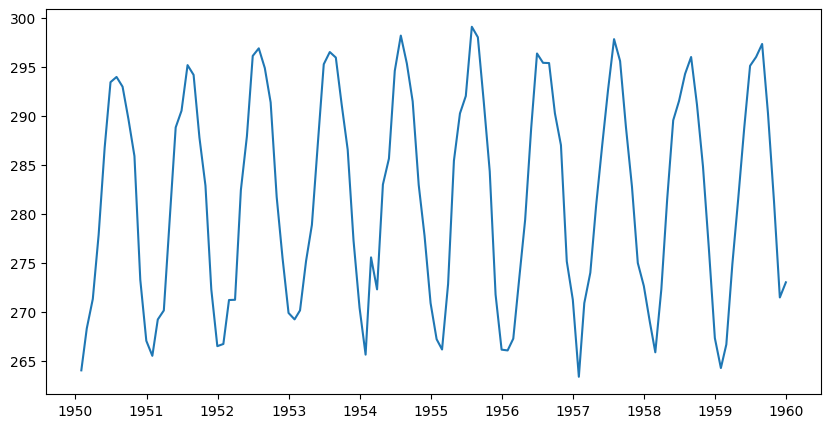

In [17]:

fig,ax= plt.subplots(figsize=(10,5))
ax.plot(spatial_monthly_mean_temp.time, spatial_monthly_mean_temp)

In [18]:
client.close()

In [19]:
spatial_monthly_mean_temp

<xarray.DataArray '2m_temperature' (time: 120)> Size: 480B
array([263.9943 , 268.2754 , 271.28885, 277.85248, 286.75986, 293.4439 ,
       293.97748, 292.9813 , 289.68488, 285.8905 , 273.25827, 267.0169 ,
       265.4802 , 269.19257, 270.11554, 279.35013, 288.8218 , 290.5283 ,
       295.18594, 294.18848, 287.78934, 282.86624, 272.26794, 266.46692,
       266.69012, 271.18225, 271.20514, 282.4185 , 287.9144 , 296.12714,
       296.90192, 294.88895, 291.37766, 281.7185 , 275.50507, 269.86014,
       269.2026 , 270.1217 , 275.16266, 278.85645, 287.29596, 295.27884,
       296.5256 , 295.9606 , 291.16992, 286.54733, 277.26016, 270.38116,
       265.59976, 275.5388 , 272.27048, 282.98923, 285.63733, 294.60397,
       298.20523, 295.3526 , 291.47568, 282.94025, 277.74664, 270.86752,
       267.18057, 266.12656, 272.81583, 285.42438, 290.25052, 292.02676,
       299.10464, 298.0341 , 291.5107 , 284.33426, 271.74347, 266.10934,
       266.03134, 267.2337 , 273.45938, 279.3777 , 288.73508, 296.37448,
       295.42142, 295.39673, 290.26334, 287.00876, 275.13177, 271.21182,
       263.33804, 270.86322, 273.974  , 280.87662, 286.99118, 292.64127,
       297.84256, 295.60068, 288.86047, 282.76895, 274.96637, 272.61404,
       268.92526, 265.83908, 272.28705, 281.47592, 289.54733, 291.53143,
       294.28848, 296.01562, 291.1665 , 284.82632, 276.5128 , 267.29474,
       264.23053, 266.64093, 274.84998, 281.50305, 288.7708 , 295.1138 ,
       296.0191 , 297.34802, 290.27118, 281.26913, 271.4437 , 272.99146],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 960B 1950-01-31 1950-02-28 ... 1959-12-31

In [35]:
df = spatial_monthly_mean_temp.to_dataframe()
df['year']  = df.index.year
df['month'] = df.index.month
df['ym']    = df.index.to_period('M')
df

,2m_temperature,year,month,ym
time,,,,
1950-01-31,263.994293,1950,1,1950-01
1950-02-28,268.275391,1950,2,1950-02
1950-03-31,271.288849,1950,3,1950-03
1950-04-30,277.852478,1950,4,1950-04
1950-05-31,286.759857,1950,5,1950-05
...,...,...,...,...
1959-08-31,297.348022,1959,8,1959-08
1959-09-30,290.271179,1959,9,1959-09
1959-10-31,281.269135,1959,10,1959-10
